In [1]:
!date

Thu Nov  5 11:39:17 PST 2020


In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind, pearsonr
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
import matplotlib.ticker as ticker

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/trackfig')
from trackfig.utils import get_notebook_name
from trackfig.trackfig import trackfig 

TRACKFIG = "/home/sina/projects/mop/BYVSTZP_2020/trackfig.txt"
NB = get_notebook_name()

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
isoform = anndata.read_h5ad("../../data/notebook/revision/no_filter_isoform.h5ad")

In [3]:
gc_isoform = anndata.read_h5ad("../../data/notebook/revision/gencode_isoform.h5ad")

# set up to compare

In [4]:
gc_isoform.obs["cell_id"]=gc_isoform.obs.cell_id.apply(lambda x: x.split("/")[1])

In [5]:
cells = isoform.obs.cell_id.values

gc_cells = gc_isoform.obs.cell_id.values

In [6]:
common_cells = np.intersect1d(gc_cells, cells)

In [7]:
txn = isoform.var.index.values

gc_txn = gc_isoform.var.index.values

In [8]:
common_txn = np.intersect1d(txn, gc_txn)

In [9]:
common_txn.shape

(107639,)

In [10]:
isoform = isoform[isoform.obs.cell_id.isin(common_cells)]

gc_isoform = gc_isoform[gc_isoform.obs.cell_id.isin(common_cells)]

In [11]:
isoform = isoform[:, isoform.var.index.isin(common_txn)]
gc_isoform = gc_isoform[:, gc_isoform.var.index.isin(common_txn)]

In [12]:
isoform = isoform[isoform.obs.sort_values("cell_id").index][:,isoform.var.sort_index().index]

In [13]:
gc_isoform = gc_isoform[gc_isoform.obs.sort_values("cell_id").index][:,gc_isoform.var.sort_index().index]

# compare

In [14]:
isoform

View of AnnData object with n_obs × n_vars = 6295 × 107639
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    layers: 'X', 'log1p', 'norm'

In [15]:
gc_isoform

View of AnnData object with n_obs × n_vars = 6295 × 107639
    obs: 'cell_id'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length'
    layers: 'X', 'log1p', 'norm'

In [16]:
a = isoform.layers["norm"].todense()
b = gc_isoform.layers["norm"].todense()

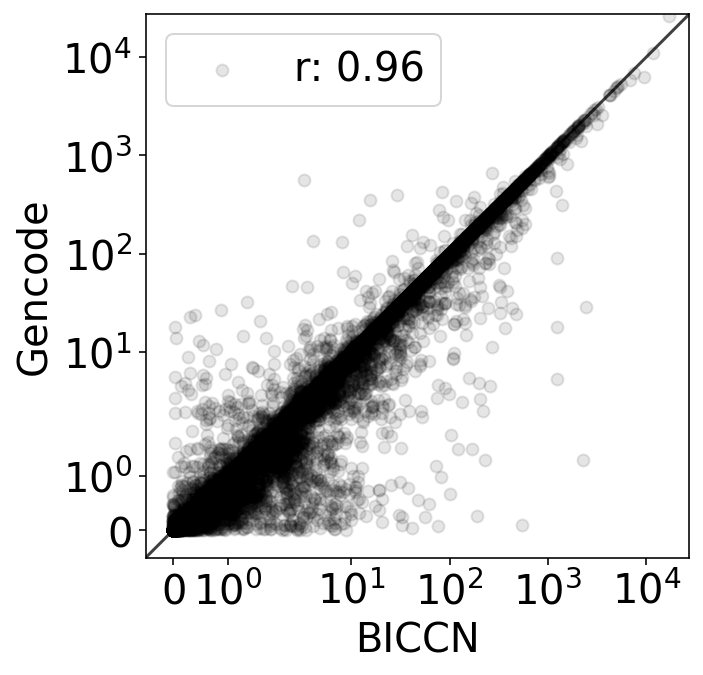

In [17]:
fig, ax = plt.subplots(figsize=(5,5))

x = nd(a.mean(axis=0))
y = nd(b.mean(axis=0))

r, p = pearsonr(x,y)

ax.scatter(x, y, alpha=0.1,label=f"r: {r:,.2f}", color="k")
yex(ax)
ax.set(**{
    "xscale": "symlog",
    "yscale": "symlog",
    "ylim": (-0.5),
    "xlim": (-0.5),
    "xlabel": "BICCN",
    "ylabel": "Gencode"
})

ax.legend()


fig.show()

In [18]:
def sparse_M_std(X):
    n = X.shape[1]
    return np.sqrt(n * X.multiply(X).sum(1) - np.multiply(X.sum(1), X.sum(1)))

def sparse_M_corr(X,Y):
    X_std = sparse_M_std(X)
    Y_std = sparse_M_std(Y)
    XY_std = np.multiply(X_std, Y_std)

    n = X.shape[1]
    XY_cov = n* X.multiply(Y).sum(1) - np.multiply(X.sum(1), Y.sum(1))
    R = np.divide(XY_cov, XY_std)
    return np.squeeze(np.asarray(R))

rcc = sparse_M_corr(isoform.layers["norm"],gc_isoform.layers["norm"])

In [19]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    color = kwd.get("color", "#D43F3A")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 2, color="grey")
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean,color="black")    
        ax.vlines(x, mean - stdev, mean+stdev, color='black', linestyle='-', lw=2)
    
    return ax

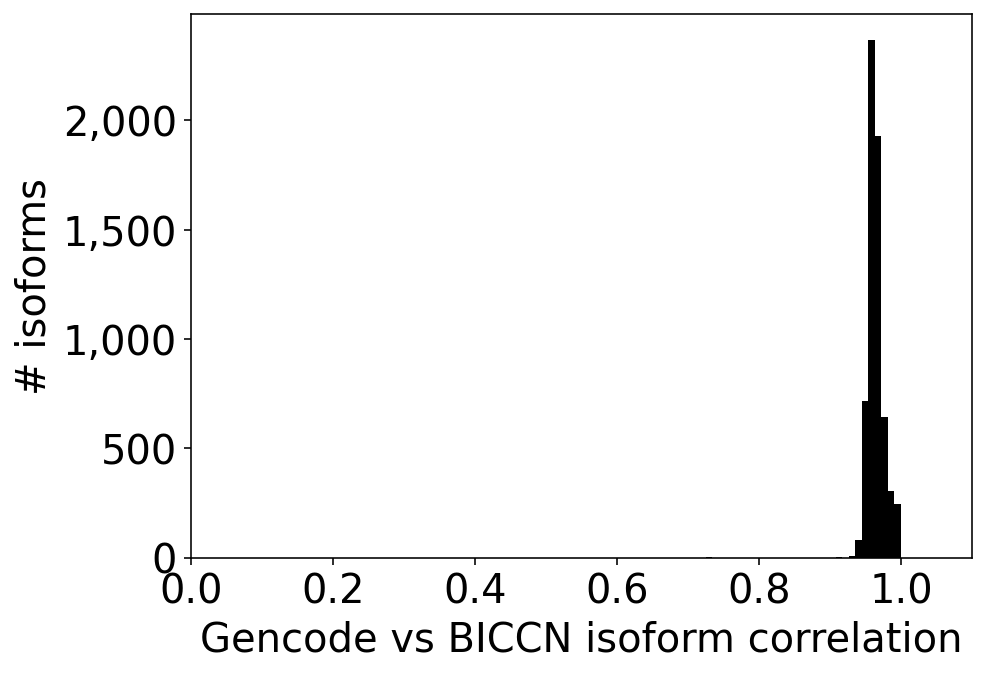

In [20]:
fig, ax = plt.subplots(figsize=(7,5))

y = rcc

ax.hist(rcc, bins=30, color="k")

ax.set(**{
    "xlim": (0, 1.1),
    "xlabel": "Gencode vs BICCN isoform correlation",
    "ylabel": "# isoforms"
})
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.savefig(trackfig("../../figures/gencode_comparison_correlation.png", TRACKFIG, NB), bbox_inches='tight', dpi=300)

fig.show()

In [21]:
rcc.mean()

0.9645082342021066